# Building A Handwritten Digits Classifier

## Introduction

Deep neural networks have been used to reach state-of-the-art performance on image classification tasks in the last decade. For some image classification tasks, deep neural networks actually perform as well as or slightly better than the human benchmark. To read about the history of deep neural networks [here](https://arxiv.org/ftp/arxiv/papers/1803/1803.01164.pdf).

Within the field of machine learning and pattern recognition, image classification (especially for handwritten text) is towards the difficult end of the spectrum. There are a few reasons for this.

First, each image in a training set is high dimensional. Each pixel in an image is a feature and a separate column. This means that a 128 x 128 image has 16384 features.

Second, images are often downsampled to lower resolutions and transformed to [grayscale](https://en.wikipedia.org/wiki/Grayscale) (no color). This is a limitation of compute power unfortunately. The resolution of a 8 megapixel photo has 3264 by 2448 pixels, for a total of 7,990,272 features (or about 8 million). Images of this resolution are usually scaled down to between 128 and 512 pixels in either direction for significantly faster processing. This often results in a loss of detail that's available for training and pattern matching.

Third, the features in an image don't have an obvious linear or nonlinear relationship that can be learned with a model like linear or logistic regression. In grayscale, each pixel is just represented as a brightness value ranging from 0 to 256. 

The goal of this project is to explore the effectiveness of deep, feedforward neural networks at classifying images.

Scikit-learn contains a number of datasets pre-loaded with the library, within the namespace of sklearn.datasets. The load_digits() function returns a copy of the hand-written digits dataset from UCI.

Because data frames are a tabular representation of data, each image is represented as a row of pixel values. I am going to load this data, reshape and visualize some of them.

## Working With Image Data

In [1]:
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
# transform the NumPy 2D array into a pandas dataframe
data, target = load_digits(return_X_y = True)
data = pd.DataFrame(data)
target = pd.Series(target)
print(data.shape)

(1797, 64)


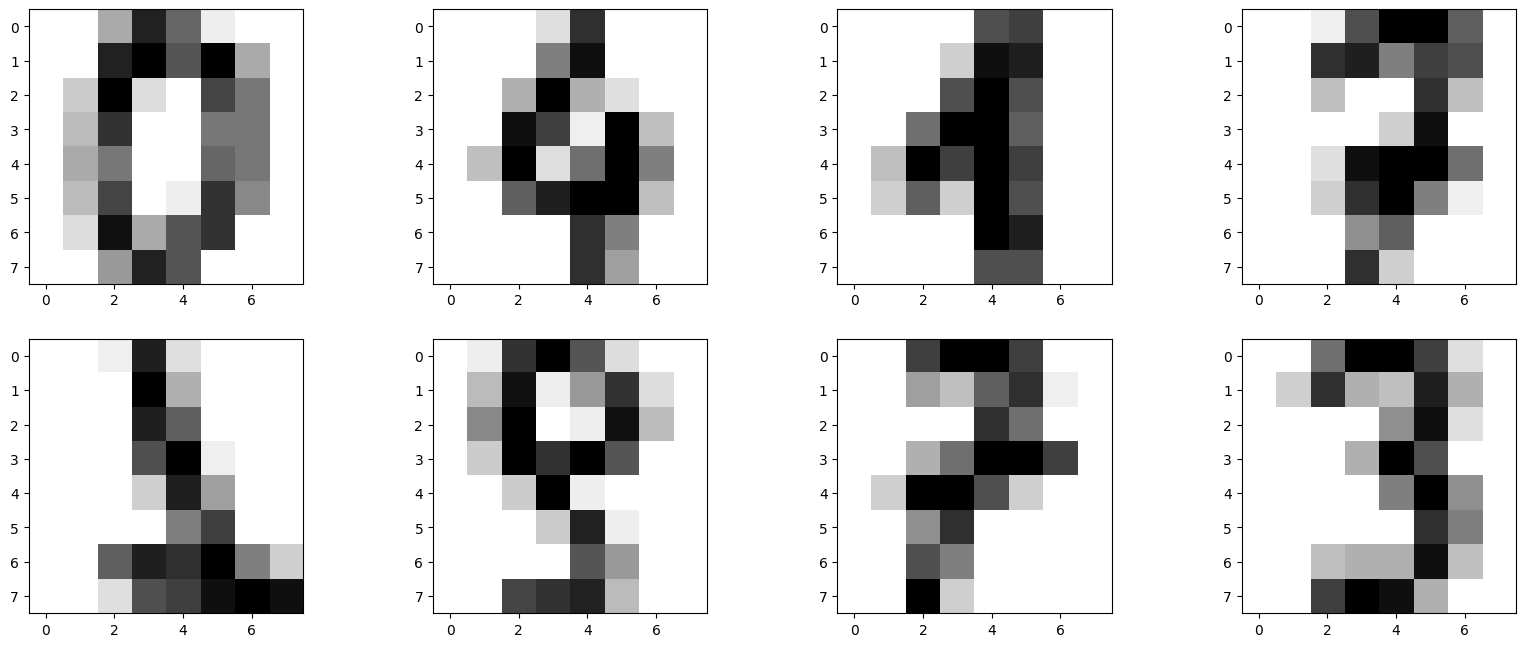

In [3]:
# use matplotlib to visualize some of the images in the dataset
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
rows = [0, 100, 200, 300, 1000, 1100, 1200, 1300]
plt_num = 0
for i in rows:
    first_image = data.iloc[i]
    np_image = first_image.values
    np_image = np_image.reshape(8,8)
    plt_num += 1
    ax = plt.subplot(2,4,plt_num)
    plt.imshow(np_image, cmap='gray_r', interpolation='nearest')

## Neural Network With One Hidden Layer

While linear and logistic regression models make assumptions about the linearity between the features and the output labels, the k-nearest neighbors algorithm make no such assumption. This allows them to capture nonlinearity in the data.

Let's use the KNeighborsClassifier package to train and test k-nearest neighbors models. Also I will use 4-fold cross validation.

In [4]:
def train(nneighbors, train_features, train_labels):
    knn = KNeighborsClassifier(n_neighbors = nneighbors)
    knn.fit(train_features, train_labels)
    return knn

def test(model, test_features, test_target):
    predictions = model.predict(test_features)
    train_result = pd.DataFrame()
    train_result['true_result'] = test_target
    train_result['prediction'] = predictions
    accuracy = sum(train_result["prediction"] == train_result["true_result"])/len(train_result)    
    return accuracy

def cross_validate(k):
    fold_accuracies = []
    kf = KFold(n_splits = 6, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = target.loc[train_index], target.loc[test_index]
        model = train(k, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies
       


In [5]:
knn_one_accuracies = cross_validate(1)
np.mean(knn_one_accuracies)


0.9872054998141954

Let's experiment with different values for k and plot the resulting classification accuracies.

In [6]:
mean_all_accuracies = list()

for k in range(1,15):
    knn_accuracies = cross_validate(k) 
    mean_all_accuracies.append(np.mean(knn_accuracies))


In [7]:
mean_all_accuracies

[0.9872054998141954,
 0.9844128576737273,
 0.9855314009661834,
 0.9849721293199553,
 0.9844184318097362,
 0.9821869193608324,
 0.9833054626532887,
 0.9827461910070606,
 0.981079524340394,
 0.9805239687848384,
 0.9805258268301746,
 0.9805258268301745,
 0.9805295429208473,
 0.9788591601635078]

Text(0, 0.5, 'Mean of accuracy')

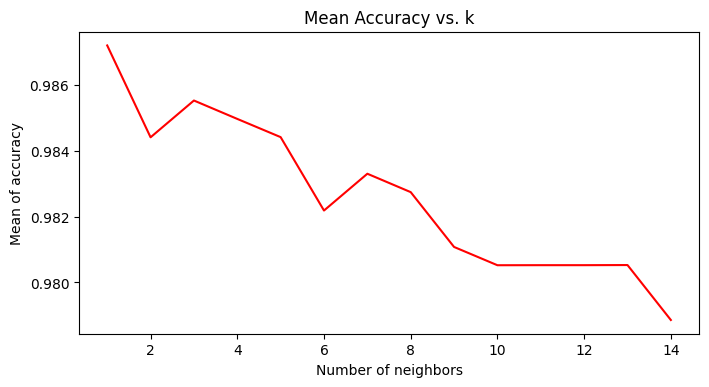

In [8]:
plt.figure(figsize=(8,4))
x = range(1, 15)
y = mean_all_accuracies
plt.plot(x, y, color = 'red')
plt.title("Mean Accuracy vs. k")
plt.xlabel('Number of neighbors')
plt.ylabel('Mean of accuracy')


The highest level of mean accuracy is 0.987 when the number of neighbors is 1. And I see that increasing number of neighbors make the mean accuracy lower.

There are a few downsides to using k-nearest neighbors:

- high memory usage (for each new unseen observation, many comparisons need to be made to seen observations)
- no model representation to debug and explore

Let's now try a neural network with a single hidden layer.

## Neural Network With One Hidden Layer


In [9]:
def train_nn(neuron_num, train_features, train_target):
    mlp = MLPClassifier(hidden_layer_sizes=neuron_num, random_state = 2)
    mlp.fit(train_features, train_target)
    return mlp

def test(model, test_features, test_target):
    predictions = model.predict(test_features)
    train_result = pd.DataFrame()
    train_result['true_result'] = test_target
    train_result['prediction'] = predictions
    accuracy = sum(train_result["prediction"] == train_result["true_result"])/len(train_result)    
    return accuracy

def cross_validate(neuron_num):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = target.loc[train_index], target.loc[test_index]
        model = train_nn(neuron_num, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies


accuracies = cross_validate((8,))
np.mean(accuracies)


0.9298799802029201

In [10]:
neurons = [(8,), (16,), (32,), (64,), (128,), (256,)]
nn_one_accuracies = list()


for neuron in neurons:
    neurons_accuracies = cross_validate(neuron) 
    nn_one_accuracies.append(np.mean(neurons_accuracies))


In [11]:
nn_one_accuracies

[0.9298799802029201,
 0.9554875030932937,
 0.9682863152684978,
 0.9721826280623608,
 0.9755209106656768,
 0.9783036377134373]

Text(0, 0.5, 'Mean of Accuracy')

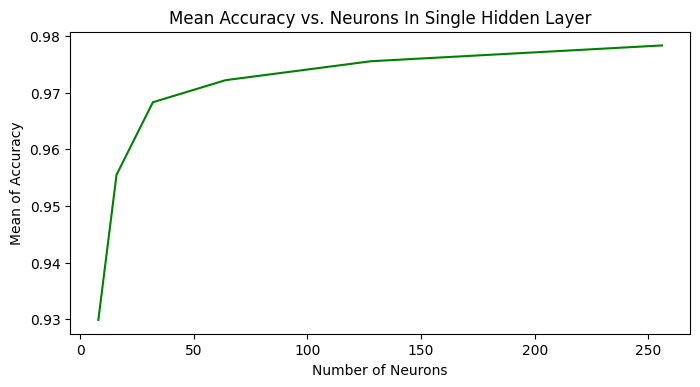

In [12]:
plt.figure(figsize=(8,4))
x = neurons
y = nn_one_accuracies
plt.plot(x, y, color = 'green')
plt.title("Mean Accuracy vs. Neurons In Single Hidden Layer")
plt.xlabel('Number of Neurons')
plt.ylabel('Mean of Accuracy')


It looks like adding more neurons to the single hidden layer improved simple accuracy to approximately 97%. Simple accuracy computes the number of correct classifications the model made, but doesn't tell us anything about false or true positives or false or true negatives.

Given that k-nearest neighbors achieved approximately 98% accuracy, there doesn't seem to be any advantages to using a single hidden layer neural network for this problem.

## Neural Network With Two Hidden Layers

Let's try using two hidden layers and continue to increase the number of neurons in each layer.

In [13]:
two_neurons = [(64, 64), (128, 128), (256, 256)]
nn_two_accuracies = list()


for neuron in two_neurons:
    neurons_accuracies = cross_validate(neuron) 
    nn_two_accuracies.append(np.mean(neurons_accuracies))



In [14]:
nn_two_accuracies

[0.9694023756495918, 0.9799715416975996, 0.9827567433803515]

Text(0, 0.5, 'Mean of Accuracy')

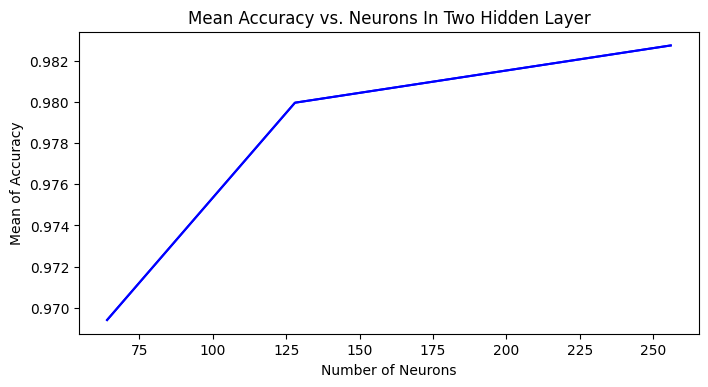

In [15]:
plt.figure(figsize=(8,4))
x = two_neurons
y = nn_two_accuracies
plt.plot(x, y, color = 'blue')
plt.title("Mean Accuracy vs. Neurons In Two Hidden Layer")
plt.xlabel('Number of Neurons')
plt.ylabel('Mean of Accuracy')


The accuracy of the test data set has improved to 98%. Using more hidden layers is known to increase the amount of overfitting that happens. To help us prevent overfitting, let's increase the number of folds we use for k-fold cross validation to 6 while testing networks with 3 hidden layers.


## Neural Network With Three Hidden Layers

In [16]:
def train_nn(neuron_num, train_features, train_target):
    mlp = MLPClassifier(hidden_layer_sizes=neuron_num, random_state = 2)
    mlp.fit(train_features, train_target)
    return mlp

def test(model, test_features, test_target):
    predictions = model.predict(test_features)
    train_result = pd.DataFrame()
    train_result['true_result'] = test_target
    train_result['prediction'] = predictions
    accuracy = sum(train_result["prediction"] == train_result["true_result"])/len(train_result)    
    return accuracy

def cross_validate(neuron_num):
    fold_accuracies = []
    kf = KFold(n_splits = 6, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = target.loc[train_index], target.loc[test_index]
        model = train_nn(neuron_num, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies



In [17]:
three_neurons = [(10, 10, 10), (64, 64, 64), (128, 128, 128)]
nn_three_accuracies = list()

for neuron in three_neurons:
    neurons_accuracies = cross_validate(neuron) 
    nn_three_accuracies.append(np.mean(neurons_accuracies))


In [18]:
nn_three_accuracies

[0.9471367521367521, 0.9744109996283911, 0.9771924934968412]

Text(0, 0.5, 'Mean of Accuracy')

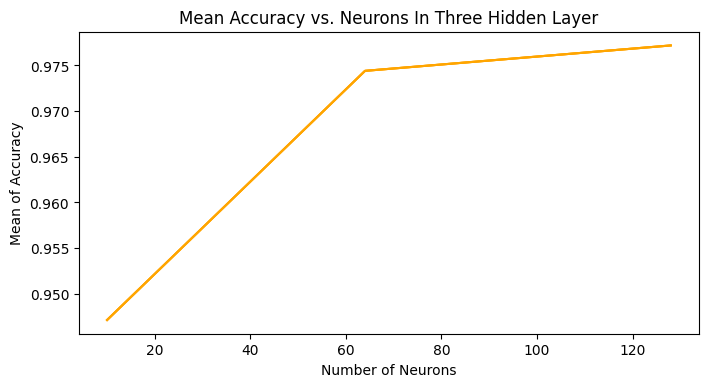

In [19]:
plt.figure(figsize=(8,4))
x = three_neurons
y = nn_three_accuracies
plt.plot(x, y, color = 'orange')
plt.title("Mean Accuracy vs. Neurons In Three Hidden Layer")
plt.xlabel('Number of Neurons')
plt.ylabel('Mean of Accuracy')


## Conclusion

I've been experimented with different models to classify handwritten digits. As I see three hidden layers the accuracy increases from 0.947 to 0.977 approximately. This one has a better accuracy than K-Nearest Neighbors. This goes accodingly with the literature about computer vision, the theory says that with more layers the model will work better.

Next steps:

- Use the existing pipeline to try other machine learning models:     
  - Decision Tree Models     
  - Random Forest Models
- Experiment with different activation functions to see if the accuracies improve.
- Apply some regularization methods to solve overfitting.
